<a href="https://colab.research.google.com/github/Ziyi-star/Bachelorarbeit/blob/main/notebooks/training/train_simclr_har_0.5s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SimCLR Training

In [ ]:
# For VSCode
%load_ext autoreload
%autoreload 2

import os
import pickle
import scipy
import datetime
import numpy as np
import tensorflow as tf
import simclr_utitlities
import transformations
import simclr_models
import sys
import matplotlib.pyplot as plt

sys.path.append('../')   # Add parent directory to Python path
working_directory = "../models/"

seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)

# todo: Load data need to be changed according to your path
with open('../../data/TrainTest_one/X_train_data_normalized.pkl', 'rb') as f:
    np_train_data = pickle.load(f)
with open('../../data/TrainTest_one/y_train_label_onehot.pkl', 'rb') as f:
    np_train_labels = pickle.load(f)
np_train_data.shape, np_train_labels.shape

((848, 50, 3), (848, 7))

In [1]:
# For Google Colab
# 1. Clone your repository to go to access your notebook and .py files
!git clone https://github.com/Ziyi-star/Bachelorarbeit.git
# 2. Change working directory to where your notebook and .py files are
import os
os.chdir('/content/Bachelorarbeit/notebooks/training')
import os
import pickle
import scipy
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import simclr_utitlities
import transformations
import simclr_models
import sys

seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)

# Load data
# Download the file from GitHub
!wget https://raw.githubusercontent.com/Ziyi-star/Bachelorarbeit/main/notebooks/data_0.5s/X_train_normalized.pkl
!wget https://raw.githubusercontent.com/Ziyi-star/Bachelorarbeit/main/notebooks/data_0.5s/y_train_onehot.pkl
!wget https://raw.githubusercontent.com/Ziyi-star/Bachelorarbeit/main/notebooks/data_0.5s/X_val_normalized.pkl
!wget https://raw.githubusercontent.com/Ziyi-star/Bachelorarbeit/main/notebooks/data_0.5s/y_val_onehot.pkl


working_directory = "../models/"  # Relative path to models folder

# Load as usual
import pickle

with open('X_train_normalized.pkl', 'rb') as f:
    np_train_data = pickle.load(f)
with open('y_train_onehot.pkl', 'rb') as f:
    np_train_labels = pickle.load(f)
with open('X_val_normalized.pkl', 'rb') as f:
    np_val_data = pickle.load(f)
with open('y_val_onehot.pkl', 'rb') as f:
    np_val_labels = pickle.load(f)

print(np_train_data.shape, np_train_labels.shape)
print(np_val_data.shape, np_val_labels.shape)


Cloning into 'Bachelorarbeit'...
remote: Enumerating objects: 274, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 274 (delta 18), reused 23 (delta 9), pack-reused 234 (from 1)
Receiving objects: 100% (274/274), 52.19 MiB | 21.38 MiB/s, done.
Resolving deltas: 100% (130/130), done.


/content/Bachelorarbeit/notebooks/training/transformations.py:35: SyntaxWarning: invalid escape sequence '\&'
  @inproceedings{TerryUm_ICMI2017, author = {Um, Terry T. and Pfister, Franz M. J. and Pichler, Daniel and Endo, Satoshi and Lang, Muriel and Hirche, Sandra and Fietzek, Urban and Kuli\'{c}, Dana}, title = {Data Augmentation of Wearable Sensor Data for Parkinson's Disease Monitoring Using Convolutional Neural Networks}, booktitle = {Proceedings of the 19th ACM International Conference on Multimodal Interaction}, series = {ICMI 2017}, year = {2017}, isbn = {978-1-4503-5543-8}, location = {Glasgow, UK}, pages = {216--220}, numpages = {5}, doi = {10.1145/3136755.3136817}, acmid = {3136817}, publisher = {ACM}, address = {New York, NY, USA}, keywords = {Parkinson\&#39;s disease, convolutional neural networks, data augmentation, health monitoring, motor state detection, wearable sensor}, }


--2025-09-09 13:46:35--  https://raw.githubusercontent.com/Ziyi-star/Bachelorarbeit/main/notebooks/data_0.5s/X_train_normalized.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1017765 (994K) [application/octet-stream]
Saving to: ‘X_train_normalized.pkl’

X_train_normalized. 100%[===================>] 993.91K  --.-KB/s    in 0.04s   

2025-09-09 13:46:36 (27.4 MB/s) - ‘X_train_normalized.pkl’ saved [1017765/1017765]

--2025-09-09 13:46:36--  https://raw.githubusercontent.com/Ziyi-star/Bachelorarbeit/main/notebooks/data_0.5s/y_train_onehot.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... co

In [2]:
# Parameters for all experiments
window_size = 50
input_shape = (window_size, 3)
batch_size = 512
#Number of samples processed together in one training step. Larger batch sizes can speed up training but require more memory.
decay_steps = 1000
#Number of steps after which the learning rate decays (used for learning rate scheduling).
epochs = 200
temperature = 0.1


In [3]:
# # transformation_indices = [2] # Use rotation transformation only
# # transformation_indices = [1, 2] # Use Scaling and rotation transformation
# transformation_indices = [5, 7] # Use channel shuffle and permutation transformation

# transform_funcs_vectorized = [
#     # 0. Adding random Gaussian noise.
#     transformations.noise_transform_vectorized,
#     # 1. Scaling by a random factor
#     transformations.scaling_transform_vectorized,
#     # 2. Applying a random 3D rotation
#     transformations.rotation_transform_vectorized,
#     # 3. Inverting the signals.
#     transformations.negate_transform_vectorized,
#     # 4. Reversing the direction of time
#     transformations.time_flip_transform_vectorized,
#     # 5. Randomly scrambling sections of the signal.
#     transformations.time_segment_permutation_transform_improved,
#     # 6. Stretching and warping the time-series
#     transformations.time_warp_transform_low_cost,
#     # 7. Shuffling the different channels.
#     transformations.channel_shuffle_transform_vectorized
# ]
# # transform_funcs_names = ['noised', 'scaled', 'rotated', 'negated', 'time_flipped', 'permuted', 'time_warped', 'channel_shuffled']
# # Optionally, you can use a combined transformation function for data augmentation.
# transformation_function = simclr_utitlities.generate_combined_transform_function(
#     transform_funcs_vectorized,
#     indices=transformation_indices
# )

In [4]:
#A parameter for the SimCLR loss function that controls how sharply similarities are measured.
# transform_funcs = [
#     transformations.scaling_transform_vectorized, # Use Scaling trasnformation
#     transformations.rotation_transform_vectorized # Use rotation trasnformation
# ]
transform_funcs = [
    transformations.time_segment_permutation_transform_improved,
    transformations.channel_shuffle_transform_vectorized
]
#List of data augmentation functions to apply to the input data. Here, only rotation is used.
transformation_function = simclr_utitlities.generate_composite_transform_function_simple(transform_funcs)

0 <function time_segment_permutation_transform_improved at 0x7929c82151c0>
1 <function channel_shuffle_transform_vectorized at 0x7929c8215120>


In [5]:
# Time
start_time = datetime.datetime.now()
start_time_str = start_time.strftime("%Y%m%d-%H%M%S")
#Formats the date and time as a string like 20250827-153045 (for filenames, logs, etc.).
tf.keras.backend.set_floatx('float32')
#Sets TensorFlow to use 32-bit floating point numbers for all computations (standard for deep learning).


In [6]:
# Create a cosine-decayed learning rate schedule and SGD optimizer for training.
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

# Build the base model and attach the SimCLR head for contrastive learning.
base_model = simclr_models.create_base_model(input_shape, model_name="base_model")
simclr_model = simclr_models.attach_simclr_head(base_model)
simclr_model.summary()

# Train the SimCLR model using the specified transformation function and optimizer.
trained_simclr_model, epoch_losses = simclr_utitlities.simclr_train_model(
    simclr_model,
    np_train_data,
    optimizer,
    batch_size,
    transformation_function,
    temperature=temperature,
    epochs=epochs,
    is_trasnform_function_vectorized=True,
    verbose=1
)

# Save the trained SimCLR model to disk for later use.
simclr_model_save_path = f"{working_directory}{start_time_str}_simclr.hdf5"
trained_simclr_model.save(simclr_model_save_path)

Model: "base_model_simclr"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 50, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 27, 32)         │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 27, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 64)         │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 5, 96)          │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 96)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 96)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         6,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,594 (580.45 KB)

 Trainable params: 148,594 (580.45 KB)

 Non-trainable params: 0 (0.00 B)

epoch: 1 loss: 13.380
epoch: 2 loss: 13.331
epoch: 3 loss: 13.156
epoch: 4 loss: 12.631
epoch: 5 loss: 11.849
epoch: 6 loss: 11.400
epoch: 7 loss: 11.550
epoch: 8 loss: 12.386
epoch: 9 loss: 11.396
epoch: 10 loss: 11.447
epoch: 11 loss: 10.297
epoch: 12 loss: 10.244
epoch: 13 loss: 11.003
epoch: 14 loss: 10.222
epoch: 15 loss: 10.409
epoch: 16 loss: 9.814
epoch: 17 loss: 9.924
epoch: 18 loss: 9.529
epoch: 19 loss: 9.801
epoch: 20 loss: 10.223
epoch: 21 loss: 9.668
epoch: 22 loss: 9.417
epoch: 23 loss: 9.849
epoch: 24 loss: 9.238
epoch: 25 loss: 9.349
epoch: 26 loss: 9.291
epoch: 27 loss: 8.944
epoch: 28 loss: 8.956
epoch: 29 loss: 9.469
epoch: 30 loss: 9.275
epoch: 31 loss: 9.358
epoch: 32 loss: 8.810
epoch: 33 loss: 9.146
epoch: 34 loss: 9.174
epoch: 35 loss: 8.936
epoch: 36 loss: 8.909
epoch: 37 loss: 9.038
epoch: 38 loss: 8.860
epoch: 39 loss: 8.668
epoch: 40 loss: 8.884
epoch: 41 loss: 8.676
epoch: 42 loss: 8.731
epoch: 43 loss: 8.831
epoch: 44 loss: 8.606
epoch: 45 loss: 8.298
epo

epoch: 199 loss: 7.225
epoch: 200 loss: 6.315


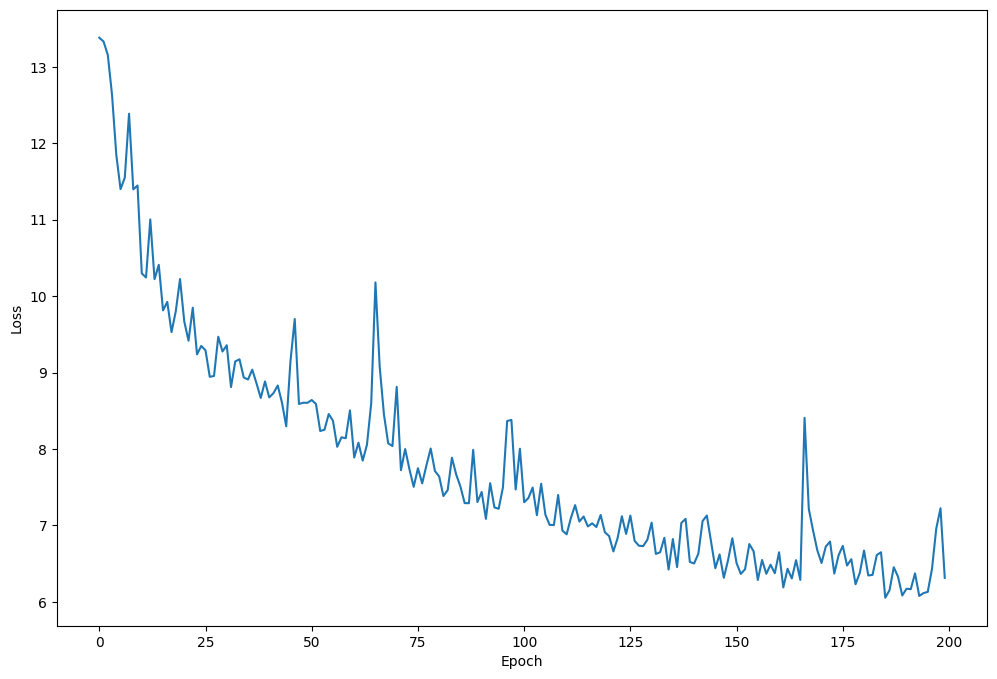

In [7]:
plt.figure(figsize=(12,8))
plt.plot(epoch_losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

## Fine-tuning and Evaluation

### Linear Model

In [9]:
# This block performs linear evaluation on top of the pretrained SimCLR base model.
total_epochs = 50
batch_size = 200
tag = "linear_eval"
output_shape = np_train_labels.shape[1]  # Number of classes for classification

# 1. Loads the SimCLR model and attaches a linear classification head.
simclr_model = tf.keras.models.load_model(simclr_model_save_path)
linear_evaluation_model = simclr_models.create_linear_model_from_base_model(simclr_model, output_shape, intermediate_layer=7)

# 2. Sets up a ModelCheckpoint callback to save the best model (lowest validation loss).
linear_eval_best_model_file_name = f"{working_directory}{start_time_str}_simclr_{tag}.keras"
best_model_callback = tf.keras.callbacks.ModelCheckpoint(
    linear_eval_best_model_file_name,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

# 3. Trains the linear evaluation model using the training and validation data.
training_history = linear_evaluation_model.fit(
    x = np_train_data,
    y = np_train_labels,
    batch_size=batch_size,
    shuffle=True,
    epochs=total_epochs,
    callbacks=[best_model_callback],
    validation_data=(np_val_data, np_val_labels)
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - auc: 0.6520 - categorical_accuracy: 0.2962 - loss: 1.7205 - precision: 0.7692 - recall: 0.1241 - val_auc: 0.8025 - val_categorical_accuracy: 0.3821 - val_loss: 1.5054 - val_precision: 1.0000 - val_recall: 0.1887
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8029 - categorical_accuracy: 0.3753 - loss: 1.4849 - precision: 0.9229 - recall: 0.2194 - val_auc: 0.8189 - val_categorical_accuracy: 0.4104 - val_loss: 1.4536 - val_precision: 1.0000 - val_recall: 0.2075
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8192 - categorical_accuracy: 0.3998 - loss: 1.4381 - precision: 0.8812 - recall: 0.2390 - val_auc: 0.8275 - val_categorical_accuracy: 0.4340 - val_loss: 1.4205 - val_precision: 1.0000 - val_recall: 0.2217
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8292 - categorical_accuracy: 0.4153 - loss: 1.4071 - precision: 0.8859 - recall: 0.2536 - val_auc: 0.8364 - val_categorical_accuracy: 0.4811 - val_loss: 1.